# Investigating Entity Extraction from User Feedback 

Hiya pure and client apps collect feedback from users. Can we extract entity names from this dataset and add them to our database?


Known Challenges:
- Feedback is often collected in unstructured format
- Users might report caller impersonating another person, or business
- Feedback is often short with one or two tokens
- Some apps only allow identity feedback on wrongly identified calls

Findings:
- some users report an identity name when flagging the call as spam - this can be a fake identity! We would not want to add fake identities to our DB 

First, let's load some data and take a look


In [30]:
import json
from itertools import islice

# File contains json stream from user-feedback kafka topic
with open('uf_sample.json') as json_file:
    
    for line in islice(json_file, 5):
        dataline = json.loads(line)
        print(json.dumps(dataline, indent=4, sort_keys=True))
        print('***************')
        
        

{
    "context": {
        "currentCarrierId": {
            "mccMnc": "310/410",
            "type": "CurrentCarrierId"
        },
        "deviceInfo": "samsung/SM-G955U",
        "gatewayName": "hiya-edge/",
        "locationHint": {
            "countryCode": "US",
            "currentCarrierId": {
                "mccMnc": "310/410",
                "type": "CurrentCarrierId"
            },
            "ipAddress": "108.65.43.66",
            "locale": {
                "country": "US",
                "language": "en"
            },
            "ownerPhoneNumber": "+13104226918",
            "simCarrierId": {
                "mccMnc": "310/410",
                "type": "SimCarrierId"
            }
        },
        "osInfo": "Android28/G955USQU5DSC1",
        "productInfo": {
            "name": "HiyaAndroid",
            "version": "9.2.2-6280"
        },
        "userDetails": {
            "applicationUserId": "O2v9LZbouuX9fjjyzzPXahKNzvX2",
            "deviceId": "c97f4f603

Looking specifically at the user feedback:

In [31]:
with open('uf_sample.json') as json_file:    
    # Show samples of user feedback
    for line in islice(json_file, 10):
        dataline = json.loads(line)
        res = json_normalize(dataline)
        print(dataline['feedback'])
        print('***************')

{'comment': {'languageTag': 'en-US', 'str': 'Keep calling with a different number and claiming that you signed up for a career school with them At my age 85 no way  🙄👀🤔'}, 'reputation': {'feedbackType': 'abstain', 'category': 6}}
***************
{'comment': {'languageTag': 'en-US', 'str': 'Didnt even speak english.'}, 'reputation': {'feedbackType': 'abstain', 'category': 2}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 8}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 2}, 'identity': {'feedbackType': 'abstain', 'name': ''}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 8}, 'identity': {'feedbackType': 'abstain', 'name': ''}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 8}, 'identity': {'feedbackType': 'abstain', 'name': ''}}
***************
{'comment': {'languageTag': 'en-US', 'str': 'employment specialist- hung up'}, 'reputation': {'feedbackType': 'abstain', 'category': 2}, 'identity'

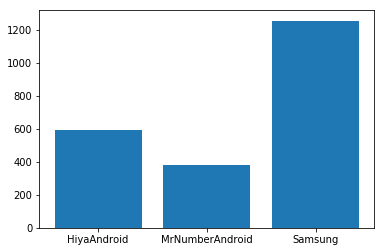

In [34]:
import matplotlib.pyplot as plt
import numpy as np

with open('uf_sample.json') as json_file:    
    product_names = []
    # Product Info
    for line in json_file:
        dataline = json.loads(line)
        product_names.append(dataline['context']['productInfo']['name'])
        
    keys, counts = np.unique(product_names, return_counts=True)
    plt.bar(keys, counts)
    plt.show()
    

In [131]:
with open('uf_sample.json') as json_file:    
    df = pd.DataFrame()
    # Product Info
    for line in json_file:
        dataline = json.loads(line)
        res = json_normalize(dataline)
        df = df.append(res, sort=True)
        
    filtered_df = df[['timestamp','phone.phone','context.productInfo.name', 'feedback.comment.languageTag','feedback.comment.str', 
                      'feedback.identity.displayName', 'feedback.identity.feedbackType','feedback.identity.name', 
                      'feedback.reputation.category', 'feedback.reputation.feedbackType']]
    
    # saving to pickle to save on processing time
    filtered_df.to_pickle('pickled_df.pkl')
    
        


In [158]:
from IPython.display import display, HTML

df = pd.read_pickle('pickled_df.pkl')
empties=['', ' ', '  ', '   ']
identity_names = df[df['feedback.identity.name'].notnull() & ~df['feedback.identity.name'].isin(empties)]
display(identity_names[['phone.phone','feedback.identity.displayName', 
                        'feedback.identity.name', 'feedback.reputation.category']])


,phone.phone,feedback.identity.displayName,feedback.identity.name,feedback.reputation.category
0,1/9176364307,NaN,sandy,2.0
0,1/8000251548,NaN,Socual Security - Officer Victor Frank,8.0
0,1/8003713515,Eddieguerra Lmt,Young Living Essential Oils,NaN
0,1/8004339891,NaN,bank of america,8.0
0,52/5547005030,NaN,Movistar,6.0
0,1/7079801272,Rita M Guanleo,Avian Glen Maintenance,NaN
0,1/3065804001,NaN,Victoria Defosse,2.0
0,1/8016212770,Sos Staffing Services,Elwood Staffing Services,NaN
0,1/4352387773,NaN,credit Card scam,2.0
0,1/8009309066,NaN,inbox loans,2.0


In [145]:
df = pd.read_pickle('pickled_df.pkl')
empties=['', ' ', '  ', '   ']
identity_names = df[df['feedback.comment.str'].notnull() & ~df['feedback.comment.str'].isin(empties)]
display(identity_names[['phone.phone', 'feedback.comment.str']])

,phone.phone,feedback.comment.str
0,1/4243090528,Keep calling with a different number and claim...
0,1/4158528601,Didnt even speak english.
0,1/9176364307,employment specialist- hung up
0,1/8000251548,Very poor recording -- Social Security nevers ...
0,1/2146742113,Medical insurance inquiry
0,1/4152697674,Low interest rate scam.
0,1/5629723879,Complete enrollment process
0,1/8056303775,"Lisa, from credit card monitoring scam"
0,1/7029351036,Medicare braces
0,1/6027227725,Credit card scam


timestamp                           2231
phone.phone                         2231
context.productInfo.name            2231
feedback.comment.languageTag         490
feedback.comment.str                 490
feedback.identity.displayName         20
feedback.identity.feedbackType      1275
feedback.identity.name               197
feedback.reputation.category        2211
feedback.reputation.feedbackType    2211
dtype: int64

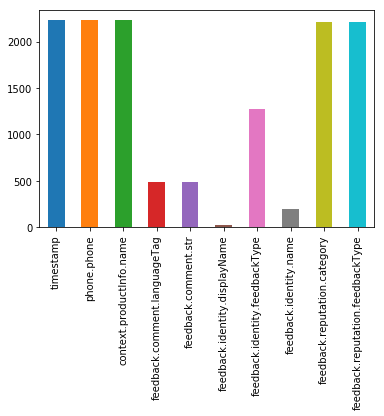

In [154]:
# replace empty strings with nan
df_no_empt = df.replace(r'^\s+$', np.nan, regex=True)
df_no_empt = df.replace('', np.nan, regex=True)
# then count and plot:
display(df_no_empt.count())
df_no_empt.count().plot.bar()

In [159]:
# what percent of feedback gives an identity name
percent_of_names = 100*(float(df_no_empt['feedback.identity.name'].count()) / df_no_empt['phone.phone'].count())
print(percent_of_names)
# what percent of feedback corrects an identity name
percent_of_names = 100*(float(df_no_empt['feedback.identity.displayName'].count()) / df_no_empt['phone.phone'].count())
print(percent_of_names)
# what percent of feedback gives an identity name, with no reputation category



8.830121021963246
0.8964589870013447
